# Convolutional Neural Network

A convolutional neural network (CNN) is a a specific type of neural net that can be used to process data with a known, grid-like topology (e.g. 2D grid of pixel values). CNNs got popular due to their excellent performance in image recognition tasks. In this notebook, we will use a basic CNN to classify the MNIST dataset.

In [1]:
import torch
import os
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from mnist import MNIST

warnings.simplefilter('ignore')
% matplotlib inline

## MNIST dataset

The MNIST dataset contains handwritten digits and is available [here](http://yann.lecun.com/exdb/mnist/). To proceed you first have to download the training data and labels and the test data and labels. Next, unpack them into a folder named "mnist" in your home directory. To make the data extraction work, you will have to rename the dots to -, for example t10k-images.idx3-ubyte must be renamed to t10k-images-idx3-ubyte.

To read the MNIST files we will use the [python mnist package](https://pypi.org/project/python-mnist/). You can install the package via

```bash
pip install python-mnist
```

Note: another convenient way to download and handle the MNIST dataset is using torchvision. Torchvision has data loaders for common datasets such as Imagenet, CIFAR10, etc. If you need an example on how to use torchvision look [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [2]:
path_to_data = os.path.expanduser("~/mnist/")
mnist = MNIST(path_to_data)

x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(f"Training set shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")

print(f"Test set shape: {x_test.shape}")
print(f"Test set shape: {y_test.shape}")

Training set shape: (60000, 784)
Training labels shape: (60000,)
Test set shape: (10000, 784)
Test set shape: (10000,)


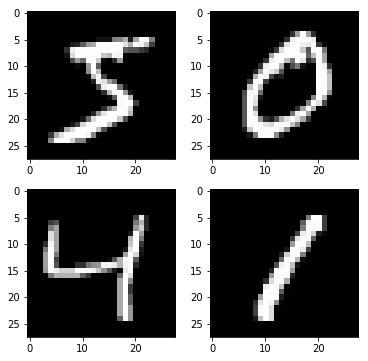

In [3]:
fig = plt.figure(figsize=(6,6))

for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(np.reshape(x_train[i], (28, 28)), cmap='gray')

## Convert data to torch tensors

In [4]:
x_train_tensor = torch.from_numpy(x_train)
x_test_tensor = torch.from_numpy(x_test)
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

## CNN layers

A convolutional neural network consists of a stack of layers. The most important layer types are: convolutional layer, pooling layer and fully connected layer. Typically, convolutional and pooling layers are used in an alternating fashion throughout the CNN. The final, fully connected layer is used to classify the extracted feature values into distinct classes.

### Convolutional layer:

A convolutional layer is a specific type of neural network layer that performs *convolutions* on an input image. The convolutions are performed by applying a certain number of convolutional filters (also called kernels) to the image. These filters are able to extract features from the input image (e.g. edges or lines). For each input region the kernel is applied to, a single value in the output feature map is produced. 

Detailed information about the functioning of convolutional layers and several illustrations can be found in the lecture notes of the [Stanford class on CNN's](http://cs231n.github.io/convolutional-networks/).


**Output shape of a convolutional layer:**   
To compute the output shape of a conv layer you need to know how a convolutional layer is structured. In summary (see Stanford class for details):

A convolutional layer:
- Accepts an input tensor of shape $W_1 \times H_1 \times D_1$ (width, height, depth)
    - The depth describes the number of color channels. For example, for MNIST we have only 1 color channel (grayscale). Most images will be in RGB mode with 3 color channels (red, blue, green)
     
- Requires four hyperparameters:
    - the number of filters $K$
    - the shape / spacial extend of the filters $F$
    - the stride $S$
    - the amount of zero padding $P$   
    common settings for padding are 'same' and 'valid'. 'same' means that the input will be padded with enough zeros to ensure that the output will have the same widht and height as the input. 'valid' means that no padding is used
     
- Produces an output tensor of shape  $W_2 \times H_2 \times D_2$
    These shapes can be computed as follows:   
    $W_2 = \frac{W_1 - F + 2P}{S} + 1$   
       
    $H_2 = \frac{H_1 - F + 2P}{S} + 1$
   
    $D_2 = K$


**Example:**

For MNIST, the input has shape $28 \times 28 \times 1$. In the first convolutional layer we will use $32$ filters with a kernel size of $5 
\times 5$. We will use "same" padding and a stride of $1$.

Therefore, the output of the first convolutional layer will have the following shape: 

$W_2 = \frac{28 - 5 + 2 * 0}{1} + 1 = 24$   
       
$H_2 = \frac{28 - 5 + 2 * 0}{1} + 1 = 24$
   
$D_2 = K = 1$
   
    

### Pooling layer:

Pooling layers are used to reduce the dimensionality of the feature maps produced by convolutional layers. A pooling function replaces the output of a convolutional layer at a certain location with a summary statistic of the nearby outputs. For example, *max pooling* computes the *maximum* output value within a rectangular neighborhood.

**Example**:

![title](figures/max_pool.png)


### Fully connected layer:

The fully connected layers are used to classify the features extracted by the convolutional and pooling layers. 

## Network parameters

In [25]:
batch_size = 100
learning_rate = 0.001
n_epochs = 10
height = width = 28
n_classes = 10

n_train_samples = x_train.shape[0]
n_test_samples = x_test.shape[0]

n_train_batches = n_train_samples // batch_size
n_test_batches = n_test_samples // batch_size

## CNN network architecture

Parts of this code were inspired by the official [Pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html).

In [26]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        # 1 input image channel (= number of color channels)
        # 32 filters/output channels
        # kernel size 5x5
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layer
        self.fc = nn.Linear(7 * 7 * 64, n_classes)
        
    def forward(self, x):
        # Max pooling with stride 2 and kernel size 2
        out = self.pool1(self.relu(self.conv1(x)))
        out = self.pool2(self.relu(self.conv2(out)))
        
        # Flatten the output
        out = out.view(-1, 7 * 7 * 64)
        out = self.fc(out)
        return out

In [27]:
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

print(cnn)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)


## Training

In [28]:
for epoch in range(n_epochs):

    print()
    print(f"Epoch: {epoch}")

    running_loss = 0.0
    
    for i in range(n_train_batches):           
        start = i * batch_size
        end = (i + 1) * batch_size

        x_batch = x_train_tensor[start:end]        
        y_batch = y_train_tensor[start:end]
        
        # Reshape the tensors and adapt their types
        x_batch = x_batch.view([batch_size, 1, height, width])
        x_batch = x_batch.type(torch.FloatTensor)
        y_batch = y_batch.type(torch.LongTensor)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = cnn(x_batch)
        loss = criterion(outputs, y_batch)
        
        # backward pass
        loss.backward()
        
        # update step
        optimizer.step()        
        
        if i % 200 == 0:
            print(f"Current minibatch loss: {loss.item():.3f}")
            
print()
print(f"Optimization done!")


Epoch: 0
Current minibatch loss: 23.885
Current minibatch loss: 0.177
Current minibatch loss: 0.084

Epoch: 1
Current minibatch loss: 0.095
Current minibatch loss: 0.076
Current minibatch loss: 0.071

Epoch: 2
Current minibatch loss: 0.087
Current minibatch loss: 0.049
Current minibatch loss: 0.079

Epoch: 3
Current minibatch loss: 0.038
Current minibatch loss: 0.020
Current minibatch loss: 0.043

Epoch: 4
Current minibatch loss: 0.030
Current minibatch loss: 0.033
Current minibatch loss: 0.090

Epoch: 5
Current minibatch loss: 0.100
Current minibatch loss: 0.032
Current minibatch loss: 0.020

Epoch: 6
Current minibatch loss: 0.013
Current minibatch loss: 0.025
Current minibatch loss: 0.014

Epoch: 7
Current minibatch loss: 0.015
Current minibatch loss: 0.010
Current minibatch loss: 0.042

Epoch: 8
Current minibatch loss: 0.065
Current minibatch loss: 0.053
Current minibatch loss: 0.024

Epoch: 9
Current minibatch loss: 0.041
Current minibatch loss: 0.012
Current minibatch loss: 0.014

## Testing

In [31]:
losses = []
acc = []

for i in range(n_test_batches):

    start = i * batch_size
    end = (i + 1) * batch_size

    x_test_batch = x_test_tensor[start:end]        
    y_test_batch = y_test_tensor[start:end]
    
    x_test_batch = x_test_batch.view([batch_size, 1, height, width])
    x_test_batch = x_test_batch.type(torch.FloatTensor)
    y_test_batch = y_test_batch.type(torch.LongTensor)

    outputs = cnn(x_test_batch)
    loss = float(criterion(outputs, y_test_batch))

    # compute accuracy
    _, predicted = torch.max(outputs.data, 1)
    equal = np.equal(predicted, y_test_batch).sum()
    accuracy = int(equal) / batch_size

    losses.append(loss)
    acc.append(accuracy)

print(f"Average loss on test set: {np.mean(losses)}")
print(f"Accuracy on test set: {int(np.mean(acc) * 100)}%")

Average loss on test set: 0.08207326166359451
Accuracy on test set: 98%
